## Variational Auto-Encoder (VAE) PyTorch implementation
Based on the paper by Larsen et al.: "Autoencoding beyond pixels using a learned similarity metric" - https://arxiv.org/abs/1512.09300

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import swifter


import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

plt.style.use('seaborn-whitegrid')

In [2]:
# Library options
pd.options.mode.chained_assignment = None  # default='warn'

# Get CPU or GPU device for NN
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
print(f"CUDA version: {torch.version.cuda}")

Using cuda device
CUDA version: 10.2


### Helper functions

In [3]:
def airfoil_info(airfoil_df, plot_airfoil, mach=0.1, reynolds=1e5):
    """
    Returns a plot of a NACA airfoil's shape, Cl and Cd between alpha = -10 and alpha = 10 degrees. 
    Assumes 15 points for upper surface and 15 points for lower surface.
    Inputs:
        - airfoil_df: pandas dataframe with airfoil data
        - plot_airfoil: index that specifies which airfoil to plot
    Outputs:
        - Plot of airfoil shape, Cl and Cd
    """
    # X coordinates
    x = [0.5*(1-np.cos(ang)) for ang in np.linspace(0,np.pi,17)]
    aux_x = list(reversed([0.5*(1-np.cos(ang)) for ang in np.linspace(0,np.pi,17)[1:16]]))
    [x.append(i) for i in aux_x]
    x.append(0)
    
    first_coord_list = airfoil_df.loc[(airfoil_df['MachNumber'] == mach) & (airfoil_df['ReynoldsNumber'] == reynolds)]['yU_1'].unique()
    plot_airfoil_df = airfoil_df.loc[(airfoil_df['MachNumber'] == mach) & (airfoil_df['ReynoldsNumber'] == reynolds) & (airfoil_df['yU_1']==first_coord_list[plot_airfoil])]
    
    # Y coordinates
    y = []
    origin = (plot_airfoil_df.iloc[1][0]+plot_airfoil_df.iloc[1][15])/2
    y.append(origin)
    [y.append(j) for j in plot_airfoil_df.iloc[1][0:15].values.tolist()]
    y.append(0)
    aux_y = list(reversed(plot_airfoil_df.iloc[1][15:30].values.tolist()))
    [y.append(k) for k in aux_y]
    y.append(origin)
    
    # Cl, Cd, alphas
    Cl = plot_airfoil_df['Cl'].values.tolist()[0:21]
    Cd = plot_airfoil_df['Cd'].values.tolist()[0:21]
    alphas = np.linspace(-10,10,len(Cl))
    
    # Airfoil plot
    plot1 = plt.subplot2grid((2,2), (0,0), colspan = 2)
    plot2 = plt.subplot2grid((2,2), (1,0))
    plot3 = plt.subplot2grid((2,2), (1,1))
    
    plot1.plot(x, y)
    plot1.set_xlim([-0.1,1.1])
    plot1.set_ylim([np.min(y)-0.2*np.abs(np.min(y)),np.max(y)+0.2*np.abs(np.max(y))])
    plot1.set_ylabel('$y/c$')
    plot1.set_xlabel('$x/c$') 
    plot1.set_title('Airfoil plot', fontsize=16)
    
    plot2.plot(alphas, Cl)
    plot2.set_xlim([-10,10])
    plot2.set_ylim([np.min(Cl)-0.1*np.abs(np.min(Cl)),np.max(Cl)+0.1*np.abs(np.max(Cl))])
    plot2.set_ylabel('$C_L$')
    plot2.set_xlabel('$\\alpha$ [$^\\circ$]') 
    
    plot3.plot(alphas, Cd)
    plot3.set_xlim([-10,10])
    plot3.set_ylim([np.min(Cd)-0.1*np.abs(np.min(Cd)),np.max(Cd)+0.1*np.abs(np.max(Cd))])
    plot3.set_ylabel('$C_D$')
    plot3.set_xlabel('$\\alpha$ [$^\\circ$]') 
 
    plt.tight_layout()
    plt.show()
    return

def airfoil_plot(airfoil_coords, fig=None, label=None):
    """
    Returns a plot of an airfoil. Used to visualize output of the optimizer. 
    Assumes 15 points for upper surface and 15 points for lower surface, with cosine spacing.
    Inputs:
        - airfoil_coords: pandas DataFrame with airfoil coordinates and other parameters
    Outputs:
        - Plot of airfoil shape
    """
    if fig==None:
        fig = plt.subplot2grid((1,3), (0,0), colspan = 3)
    # X coordinates
    x = [0.5*(1-np.cos(ang)) for ang in np.linspace(0,np.pi,17)]
    aux_x = list(reversed([0.5*(1-np.cos(ang)) for ang in np.linspace(0,np.pi,17)[1:16]]))
    [x.append(i) for i in aux_x]
    x.append(0)
    
    # Y coordinates
    y = []
    origin = (airfoil_coords.iloc[0][0]+airfoil_coords.iloc[0][15])/2
    y.append(origin)
    [y.append(j) for j in airfoil_coords.iloc[0][0:15].values.tolist()]
    y.append(0)
    aux_y = list(reversed(airfoil_coords.iloc[0][15:30].values.tolist()))
    [y.append(k) for k in aux_y]
    y.append(origin)
    
    # Airfoil plot     
    fig.plot(x, y, label = label)
    fig.set_xlim([-0.1,1.1])
    fig.set_ylim([-0.2,0.3])
    fig.set_ylabel('$y/c$')
    fig.set_xlabel('$x/c$') 
    fig.set_title('Airfoil plot', fontsize=16)
    fig.legend()
    if fig==None:
        plt.show()
    return


def torch_test_split(X, y, test_size=0.2, seed=1234):
    """
    Returns a train and test set in PyTorch tensor format from a numpy array dataset.
    Inputs:
        - X: numpy array with input data. Each row is a training/testing sample and each column is a feature.
        - y: numpy array with output data. Each row is a training/testing sample and each column is an output.
        - test_size: proportion of the dataset to be used as test set.
        - seed: random seed for reproducibility.
    Outputs:
        - training_data: PyTorch tensor with training data.
        - test_data: PyTorch tensor with test data.
    """
    X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X, y, test_size=test_size, random_state=seed)
    X_train = torch.from_numpy(X_train_0).float()
    X_test = torch.from_numpy(X_test_0).float()
    y_train = torch.from_numpy(y_train_0).float()
    y_test = torch.from_numpy(y_test_0).float()
    training_data = []
    testing_data = []
    for i in range(len(X_train)):
        training_data.append((X_train[i], y_train[i]))
    for i in range(len(X_test)):
        testing_data.append((X_test[i], y_test[i]))
    return training_data, testing_data

def normalize_data (data, scaler):
    """
    Normalizes neural network inputs and outputs.
    Inputs:
        - data: data to be normalized. [np.array / pd.DataFrame]
        - scaler: pre-fitted scaler object.
    Outputs:
        - normalized data. [pd.DataFrame]
    """
    if type(data) == pd.DataFrame:
        data = data.to_numpy().reshape(-1,scaler.n_features_in_)
    elif type(data) == np.ndarray:
        data = data.reshape(-1,scaler.n_features_in_)
    else:
        raise(TypeError('Input data must be either a pd.DataFrame or a np.ndarray'))
    norm_data = pd.DataFrame(data = scaler.transform(data), columns = scaler.feature_names_in_)
    return norm_data

def denormalize_data (data, scaler):
    """
    Denormalizes neural network inputs and outputs.
    Inputs:
        - data: data to be denormalized. [np.array / pd.DataFrame]
        - scaler: pre-fitted scaler object.
    Outputs:
        - denormalized data. [pd.DataFrame]
    """
    if type(data) == pd.DataFrame:
        data = data.to_numpy().reshape(-1,scaler.n_features_in_)
    elif type(data) == np.ndarray:
        data = data.reshape(-1,scaler.n_features_in_)
    else:
        raise(TypeError('Input data must be either a pd.DataFrame or a np.ndarray'))
    denorm_data = pd.DataFrame(data = scaler.inverse_transform(data), columns = scaler.feature_names_in_)
    return denorm_data


### Input data analysis

In [4]:
# Define input dataset (.csv) name and path
data_folder = './data/'
dataset_name = 'NACA4Digit_Dataset15Point.csv'

# Import dataset
airfoil_df = pd.read_csv(data_folder + dataset_name)
airfoil_df = airfoil_df.drop('Unnamed: 0', axis=1)    # Remove first column, counter

# Get rid of duplicates
airfoil_df = airfoil_df.drop_duplicates(subset=['yU_1', 'yL_1', 'ReynoldsNumber', 'MachNumber', 'alpha', 'Cl','Cd','Cm'])

airfoil_df.head()

,yU_1,yU_2,yU_3,yU_4,yU_5,yU_6,yU_7,yU_8,yU_9,yU_10,...,yL_12,yL_13,yL_14,yL_15,ReynoldsNumber,MachNumber,alpha,Cl,Cd,Cm
0,0.006923,0.013103,0.018233,0.022013,0.024229,0.024823,0.023923,0.021796,0.018781,0.015248,...,-0.007926,-0.004725,-0.002193,-0.000563,100000,0.1,-10,-0.334,0.16140,0.001
1,0.006923,0.013103,0.018233,0.022013,0.024229,0.024823,0.023923,0.021796,0.018781,0.015248,...,-0.007926,-0.004725,-0.002193,-0.000563,100000,0.1,-9,-0.392,0.13236,0.001
2,0.006923,0.013103,0.018233,0.022013,0.024229,0.024823,0.023923,0.021796,0.018781,0.015248,...,-0.007926,-0.004725,-0.002193,-0.000563,100000,0.1,-8,-0.442,0.10163,0.001
3,0.006923,0.013103,0.018233,0.022013,0.024229,0.024823,0.023923,0.021796,0.018781,0.015248,...,-0.007926,-0.004725,-0.002193,-0.000563,100000,0.1,-7,-0.469,0.07583,0.001
4,0.006923,0.013103,0.018233,0.022013,0.024229,0.024823,0.023923,0.021796,0.018781,0.015248,...,-0.007926,-0.004725,-0.002193,-0.000563,100000,0.1,-6,-0.459,0.05855,0.001


## 2. Autoencoder model
In this section, an MLP based encoder-decoder network will be created and trained to process airfoil coordinates.

**Inputs**
- Upper surface coordinates (15)
- Lower surface coordinates (15)

**Outputs**
- Approximately the same coordinates (network will be trained to do so)

There will be a layer in the middle that will encode the _latent features_ of the set. This is akin to a parameterization method, with arbitrary parameters.

In [5]:
# Data scaler fitting
scaler = MinMaxScaler()
scaler.fit(airfoil_df)

# Assemble a DataFrame with all the minimum and maximum values of each column
# For normalization and de-normalization. Gives an idea of the bounds.
scaler_bounds = pd.DataFrame(data = np.stack([scaler.feature_names_in_, scaler.data_min_, scaler.data_max_], axis=1), columns=['property', 'min', 'max'])

# Data normalization
airfoil_df_norm = normalize_data(airfoil_df, scaler)

# Input and "output" features
# Input and output features are both the same for this dataset.
X = airfoil_df_norm.drop(['Cl', 'Cd', 'Cm', 'ReynoldsNumber', 'MachNumber', 'alpha'], axis=1).values

# Data tensors
training_data, test_data = torch_test_split(X, X, test_size=0.2)

# Data loaders
batch_size = 512

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {y.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

C:\Users\Usuario\.conda\envs\pytorchML\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Shape of X [N, C, H, W]: torch.Size([512, 30]) torch.float32
Shape of y: torch.Size([512, 30]) torch.float32


### 2.1 Creating models

In [58]:
# Define model
class EncoderDecoder(nn.Module):
    """
    Encoder-decoder neural network based on MLP layers. 
    Widths = [64, 32, 8] for the encoder and [32, 64] for the decoder.
    Activation : ReLU.
    """
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(30, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 30)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self,x):
        encoded = self.encoder(x)
        return encoded
    
    def decode(self,x):
        decoded = self.decoder(x)
        return decoded

model = EncoderDecoder().to(device)
print(model)

EncoderDecoder(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): ReLU()
    (1): Linear(in_features=4, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=30, bias=True)
  )
)


In [59]:
# Loss function and optimizer
# As per Moin et al. (2021), use MSE loss and Adam optimizer.
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [60]:
# Define train and test functions
def train(dataloader, model, loss_fn, optimizer, loss_output = None):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    if loss_output is not None:
        loss_output.append(loss.item())
            
def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")

Epoch 1
-------------------------------
loss: 0.231465  [    0/124880]
loss: 0.035156  [51200/124880]
loss: 0.009123  [102400/124880]
Avg loss: 0.005591 

Epoch 2
-------------------------------
loss: 0.005743  [    0/124880]
loss: 0.003563  [51200/124880]
loss: 0.001795  [102400/124880]
Avg loss: 0.001146 

Epoch 3
-------------------------------
loss: 0.001102  [    0/124880]
loss: 0.000503  [51200/124880]
loss: 0.000407  [102400/124880]
Avg loss: 0.000433 

Epoch 4
-------------------------------
loss: 0.000364  [    0/124880]
loss: 0.000378  [51200/124880]
loss: 0.000317  [102400/124880]
Avg loss: 0.000357 

Epoch 5
-------------------------------
loss: 0.000292  [    0/124880]
loss: 0.000314  [51200/124880]
loss: 0.000253  [102400/124880]
Avg loss: 0.000303 

Epoch 6
-------------------------------
loss: 0.000238  [    0/124880]
loss: 0.000262  [51200/124880]
loss: 0.000201  [102400/124880]
Avg loss: 0.000256 

Epoch 7
-------------------------------
loss: 0.000196  [    0/124880]

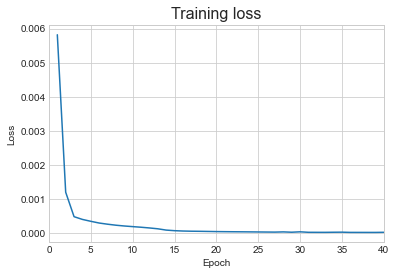

In [61]:
# Run training
epochs = 40
loss_plot = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, loss_output = loss_plot)
    test(test_dataloader, model, loss_fn)
print("Done!")

# Loss plot
plt.plot(range(1, epochs+1), loss_plot)
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.title('Training loss', fontsize=16)
plt.xlim([0,epochs])
plt.show()

### Latent variable comparison (20 epochs)
- 8 latent variables: Loss = 3.6e-5
- 4 latent variables: Loss = 3.9e-5  
  
A network with 4 latent variables is more than capable of reproducing the airfoils.  
After 40 epochs of training, the loss for a 4 latent variable network is 2.8e-5.

### 2.3 Saving the model

In [62]:
save_model = True
if save_model:
    trained_root = "./trained_models/"
    model_name = "AE_MLP64_30.pth"
    
    model_path = trained_root + model_name
    torch.save(model.state_dict(), model_path)
    print(f"Saved PyTorch Model State to {model_path}")

Saved PyTorch Model State to ./trained_models/AE_MLP64_30.pth


### 2.4 Loading the model

In [63]:
# For these sections, the cpu will be used
device = 'cpu'
model = EncoderDecoder().to(device)
model_root = "./trained_models/"
model_name = "AE_MLP64_30.pth"

model_path = model_root + model_name
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

### 2.5 Making predictions on random airfoils

------ Comparison ------


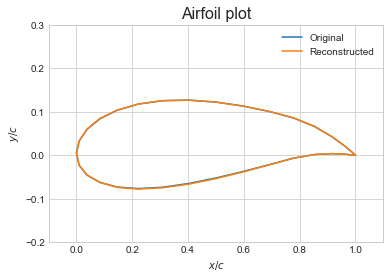

In [118]:
idxpred = np.random.randint(0, len(test_data))
x, y = test_data[idxpred][0].to(device), test_data[idxpred][1].to(device)
dummy = np.array([0, 0, 0, 0, 0, 0]) # Dummy variable to complete the dataset rows to 36 for plotting
with torch.no_grad():
    pred = model(x)
    reconstructed = denormalize_data(np.concatenate((pred.cpu().numpy(), dummy), axis=0),scaler)
    original = denormalize_data(np.concatenate((x.cpu().numpy(), dummy), axis=0),scaler)
    plot1 = plt.subplot2grid((1,3), (0,0), colspan = 3)
    print("------ Comparison ------")
    airfoil_plot(original, fig=plot1, label="Original")
    airfoil_plot(reconstructed, fig=plot1, label="Reconstructed")

In [ ]:
[0.031161,-0.047598,-0.102501,-0.035861]

### Random airfoil generation

Once the Autoencoder has been proven to work well, we will do an encoding pass to the whole dataset to replace airfoil coordinates (30 variables) with latent variables (4 variables).  
This allows us to know the latent space variable range in order to sample variables correctly.

## Reformulate the dataset using latent variables
Recreate the dataset with the latent variables and obtain the range of such variables to measure our design space.

In [69]:
# -- New database ---
# Choose whether to process the old database. It will be saved in ./data/

process_database = True
if process_database:
    def encode_coords(row, model):
        """
        Encodes the coordinates of a row of the dataset. Uses an autoencoder model to encode the coordinates.
        Inputs:
        - row: A row of the dataset. Contains 30 coordinate points.
        - model: An autoencoder model.
        Outputs:
        - encoded: The encoded coordinates of the row.
        """
        return model.encode(torch.Tensor(row.iloc[:][0:30].values.reshape(-1,30)).to(device)).detach().cpu().numpy()[0]
    
    def decode_coords(row, model):
        """
        Decodes the coordinates of a row of the dataset. Uses an autoencoder model to decode the coordinates.
        Inputs:
        - row: A row of the dataset. Contains 4 latent variables.
        - model: An autoencoder model.
        Outputs:
        - decoded: The decoded coordinates of the row.
        """
        return model.decode(torch.Tensor(row.iloc[:][0:4].values.reshape(-1,4)).to(device)).detach().cpu().numpy()[0]    

    # --- New dataset ---
    airfoil_df_encoded = airfoil_df_norm.copy(deep=True)
    # Drop the columns containing original coordinates
    airfoil_df_encoded = airfoil_df_encoded[airfoil_df_encoded.columns.drop(list(airfoil_df_encoded.filter(regex='^y')))]

    encoded_coords = airfoil_df.apply(encode_coords, axis=1, model=model)

    airfoil_df_encoded['feat1'] = [i[0] for i in encoded_coords]
    airfoil_df_encoded['feat2'] = [i[1] for i in encoded_coords]
    airfoil_df_encoded['feat3'] = [i[2] for i in encoded_coords]
    airfoil_df_encoded['feat4'] = [i[3] for i in encoded_coords]

    cols = airfoil_df_encoded.columns.tolist()
    cols = cols[-4:] + cols[:-4]
    airfoil_df_encoded = airfoil_df_encoded[cols]
    airfoil_df_encoded.to_csv("./data/NACA4Digit_Dataset15Point_encoded4.csv", index=True)
    airfoil_df_encoded



### Analyze design space

In [70]:
# Define input dataset (.csv) name and path
data_folder = './data/'
dataset_name = 'NACA4Digit_Dataset15Point_encoded4.csv'

# Import dataset
airfoil_df_encoded = pd.read_csv(data_folder + dataset_name)
airfoil_df_encoded = airfoil_df_encoded.drop('Unnamed: 0', axis=1)    # Remove first column, counter
display(airfoil_df_encoded)
# Data scaler fitting
scaler_enc = MinMaxScaler()
scaler_enc.fit(airfoil_df_encoded)

# Assemble a DataFrame with all the minimum and maximum values of each column
# For normalization and de-normalization. Gives an idea of the bounds.
scaler_enc_bounds = pd.DataFrame(data = np.stack([scaler_enc.feature_names_in_, scaler_enc.data_min_, scaler_enc.data_max_], axis=1), columns=['property', 'min', 'max'])
scaler_enc_bounds['delta'] = [(scaler_enc_bounds[scaler_enc_bounds['property']==feat]['max'].values[0]-scaler_enc_bounds[scaler_enc_bounds['property']==feat]['min'].values[0]) for feat in scaler_enc_bounds['property'].values]
scaler_enc_bounds

,feat1,feat2,feat3,feat4,ReynoldsNumber,MachNumber,alpha,Cl,Cd,Cm
0,0.028624,0.169807,-0.105617,0.111013,0.0,0.0,0.00,0.219528,0.206647,0.960265
1,0.028624,0.169807,-0.105617,0.111013,0.0,0.0,0.05,0.206745,0.168394,0.960265
2,0.028624,0.169807,-0.105617,0.111013,0.0,0.0,0.10,0.195724,0.127916,0.960265
3,0.028624,0.169807,-0.105617,0.111013,0.0,0.0,0.15,0.189773,0.093932,0.960265
4,0.028624,0.169807,-0.105617,0.111013,0.0,0.0,0.20,0.191977,0.071170,0.960265
...,...,...,...,...,...,...,...,...,...,...
156096,0.076631,0.101553,0.029263,0.419093,1.0,1.0,0.80,0.913599,0.052373,0.004415
156097,0.076631,0.101553,0.029263,0.419093,1.0,1.0,0.85,0.937404,0.056061,0.002208
156098,0.076631,0.101553,0.029263,0.419093,1.0,1.0,0.90,0.959885,0.060276,0.002208
156099,0.076631,0.101553,0.029263,0.419093,1.0,1.0,0.95,0.980824,0.064781,0.000000


,property,min,max,delta
0,feat1,-0.020525,0.126409,0.146934
1,feat2,0.055133,0.256218,0.201085
2,feat3,-0.107187,0.129389,0.236576
3,feat4,0.111013,0.431758,0.320745
4,ReynoldsNumber,0.0,1.0,1.000000
5,MachNumber,0.0,1.0,1.000000
6,alpha,0.0,1.0,1.000000
7,Cl,0.0,1.0,1.000000
8,Cd,0.0,1.0,1.000000
9,Cm,0.0,1.0,1.000000


[0.023351375392130544, 0.24317743388789292, -0.09925491545602463, 0.19593661367040652]


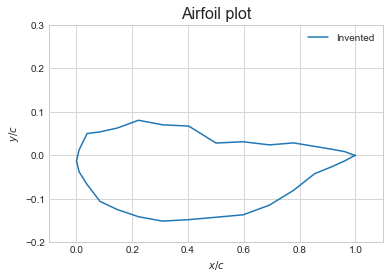

In [94]:
latent_random = [np.random.rand()*(scaler_enc_bounds[scaler_enc_bounds['property']=='feat1']['delta'].values[0])+scaler_enc_bounds[scaler_enc_bounds['property']=='feat1']['min'].values[0],
                 np.random.rand()*(scaler_enc_bounds[scaler_enc_bounds['property']=='feat2']['delta'].values[0])+scaler_enc_bounds[scaler_enc_bounds['property']=='feat2']['min'].values[0],
                 np.random.rand()*(scaler_enc_bounds[scaler_enc_bounds['property']=='feat3']['delta'].values[0])+scaler_enc_bounds[scaler_enc_bounds['property']=='feat3']['min'].values[0],
                 np.random.rand()*(scaler_enc_bounds[scaler_enc_bounds['property']=='feat4']['delta'].values[0])+scaler_enc_bounds[scaler_enc_bounds['property']=='feat4']['min'].values[0]]
print(latent_random)
invented = denormalize_data(np.concatenate((model.decode(torch.Tensor(latent_random).to(device)).detach().cpu().numpy(), dummy), axis=0),scaler)
airfoil_plot(invented, label="Invented")

,yU_1,yU_2,yU_3,yU_4,yU_5,yU_6,yU_7,yU_8,yU_9,yU_10,...,yL_12,yL_13,yL_14,yL_15,ReynoldsNumber,MachNumber,alpha,Cl,Cd,Cm
0,0.007835,0.047418,0.05198,0.061192,0.080138,0.070158,0.068273,0.027415,0.030748,0.022527,...,-0.043856,-0.027611,-0.013317,-0.002927,100000.0,0.1,-10.0,-1.33,0.00452,-0.434


AttributeError: 'Tensor' object has no attribute 'iloc'

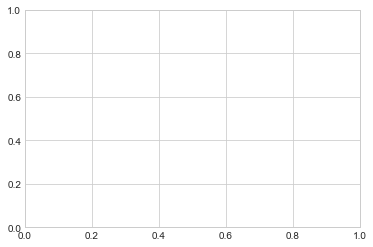

In [95]:
testi = torch.Tensor(np.array([0.028624, 0.169807, -0.105617, 0.111013])).to(device)
regen = denormalize_data(np.concatenate((model.decode(testi).detach().cpu().numpy(), dummy), axis=0),scaler)
display(regen)
airfoil_plot(testi, label="Invented")